# Table Extraction

In this notebook, we will extract tables from pdfs and save them as csv files. We will do this in two steps - first, extract tables as images, and then convert images to csv's.

In [1]:
import os
import logging
import pathlib
from dotenv import load_dotenv
from pathlib import Path

import numpy as np

from pdf2image import convert_from_path
from mmdet.apis import inference_detector, show_result_pyplot

import config
from src.data.s3_communication import S3Communication
from src.components.preprocessing import PDFTableExtractor

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [4]:
print("BASE_PDF_FOLDER:---", config.BASE_PDF_FOLDER)

BASE_PDF_FOLDER:--- opt/app-root/data/pdfs


In [2]:
# Load credentials
dotenv_dir = os.environ.get(
    "CREDENTIAL_DOTENV_DIR", os.environ.get("PWD", "/opt/app-root/src")
)
dotenv_path = pathlib.Path(dotenv_dir) / "credentials.env"
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path, override=True)

In [3]:
# init s3 connector
s3c = S3Communication(
    s3_endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("S3_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("S3_SECRET_KEY"),
    s3_bucket=os.getenv("S3_BUCKET"),
)

In [5]:
# pwd = "/opt/app-root/src"
# model_dir = "models"
# pdf_dir = "data/pdfs"
# extraction_dir = "data/extraction"

if not os.path.exists(config.CHECKPOINT_FOLDER):
    config.CHECKPOINT_FOLDER.mkdir(parents=True, exist_ok=True)

if not os.path.exists(config.BASE_PDF_FOLDER):
    config.BASE_PDF_FOLDER.mkdir(parents=True, exist_ok=True)

if not os.path.exists(config.BASE_EXTRACTION_FOLDER):
    config.BASE_EXTRACTION_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
# set file paths
PDF_FOLDER = config.BASE_PDF_FOLDER
CASCADETABNET_CONFIG_PATH = pathlib.Path("./cascade_mask_rcnn_hrnetv2p_w32_20e_v2.py").resolve()

In [6]:
# table extractor args
PDFTableExtractor_kwargs = {
    "batch_size": -1,
    # if original is used then open-mmlab/mmdetection#4397
    "cscdtabnet_config": CASCADETABNET_CONFIG_PATH,
    # _v2 loads fine but otherwise doesnt
    "cscdtabnet_ckpt": config.CHECKPOINT_FOLDER
    / "icdar_19b2_v2.pth",
    "bbox_thres": 0.85,
    "dpi": 200,
}

# init extractor
table_extractor = PDFTableExtractor(**PDFTableExtractor_kwargs)

/opt/app-root/lib64/python3.8/site-packages/mmdet/models/builder.py:51: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/mmcv/utils/misc.py:323: UserWarning: "out_size" is deprecated in `RoIAlign.__init__`, please use "output_size" instead
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/mmcv/utils/misc.py:323: UserWarning: "sample_num" is deprecated in `RoIAlign.__init__`, please use "sampling_ratio" instead
  warnings.warn(


Use load_from_local loader


### Extract tables from a single pdf file
Table Extraction happens in two stages:
1. **Infer Bounding Box:** Convert a pdf into image and use an object detection model for table recognition. The model is called CascadeTabNet. The output of this stage is the coordinates of tables.

2. **Extract tables:** from PDFs using Tabula. The coordinates are passed to tabula for analyzing that area of page.

In [7]:
# download sample data
pdf_path = PDF_FOLDER / "sustainability-report-2019.pdf"
s3c.download_file_from_s3(pdf_path, config.BASE_PDF_S3_PREFIX, "sustainability-report-2019.pdf")

### 1. Infer Bounding Box

In [8]:
# convert from pdf to sequence of images
images = convert_from_path(
    pdf_path,
    first_page=1,
    last_page=20,
    use_pdftocairo=True,
    dpi=PDFTableExtractor_kwargs["dpi"],
)

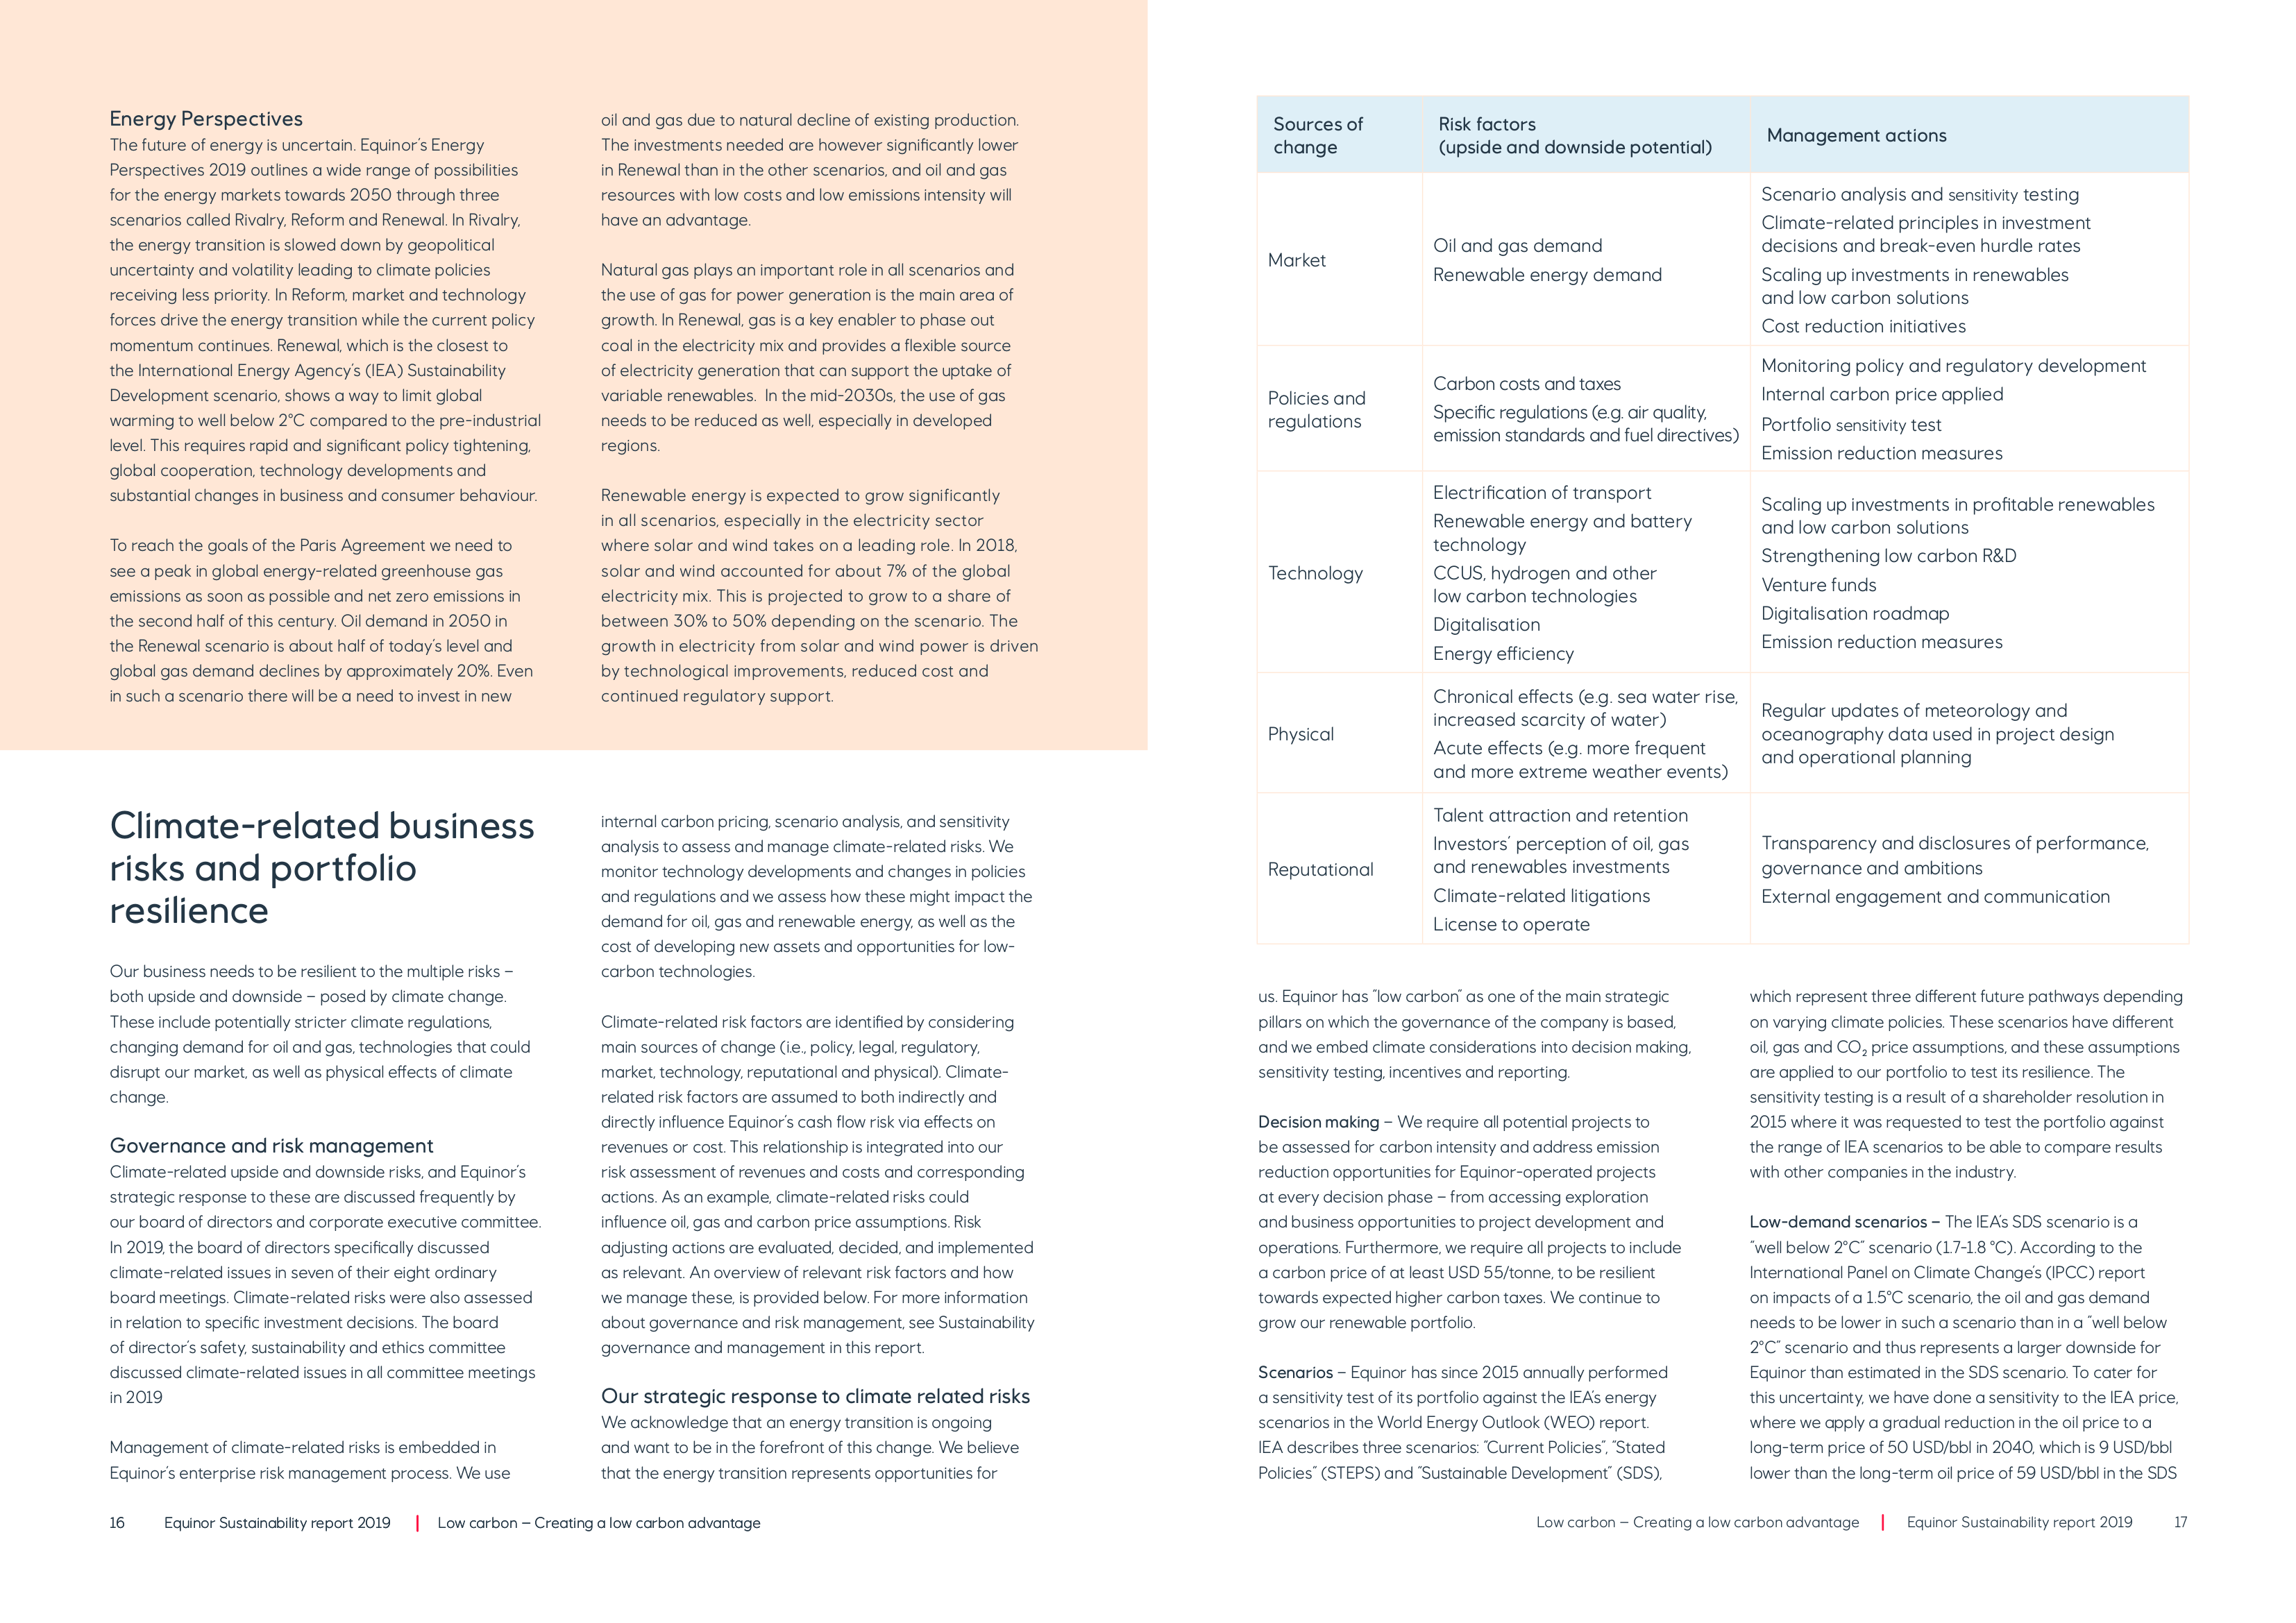

In [9]:
# view a single page (that we know contains a table)
page_num = 8
images[page_num]

In [10]:
# get bounding box coordinates for tables
temp = inference_detector(table_extractor.model, np.array(images[page_num]))
# temp = inference_detector(table_extractor.model, './demo.png')
print("Coordinates and probabilities of bordered tables\n", (temp[0][0]))
print("Coordinates and probabilities of borderless tables\n", (temp[0][2]))

/opt/app-root/lib64/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/app-root/lib64/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level

Coordinates and probabilities of bordered tables
 [[1.8177852e+03 1.7618373e+02 3.1719563e+03 1.3647517e+03 6.0830615e-02]]
Coordinates and probabilities of borderless tables
 [[1.8193606e+03 1.7796330e+02 3.1669529e+03 1.3649939e+03 9.7881240e-01]]


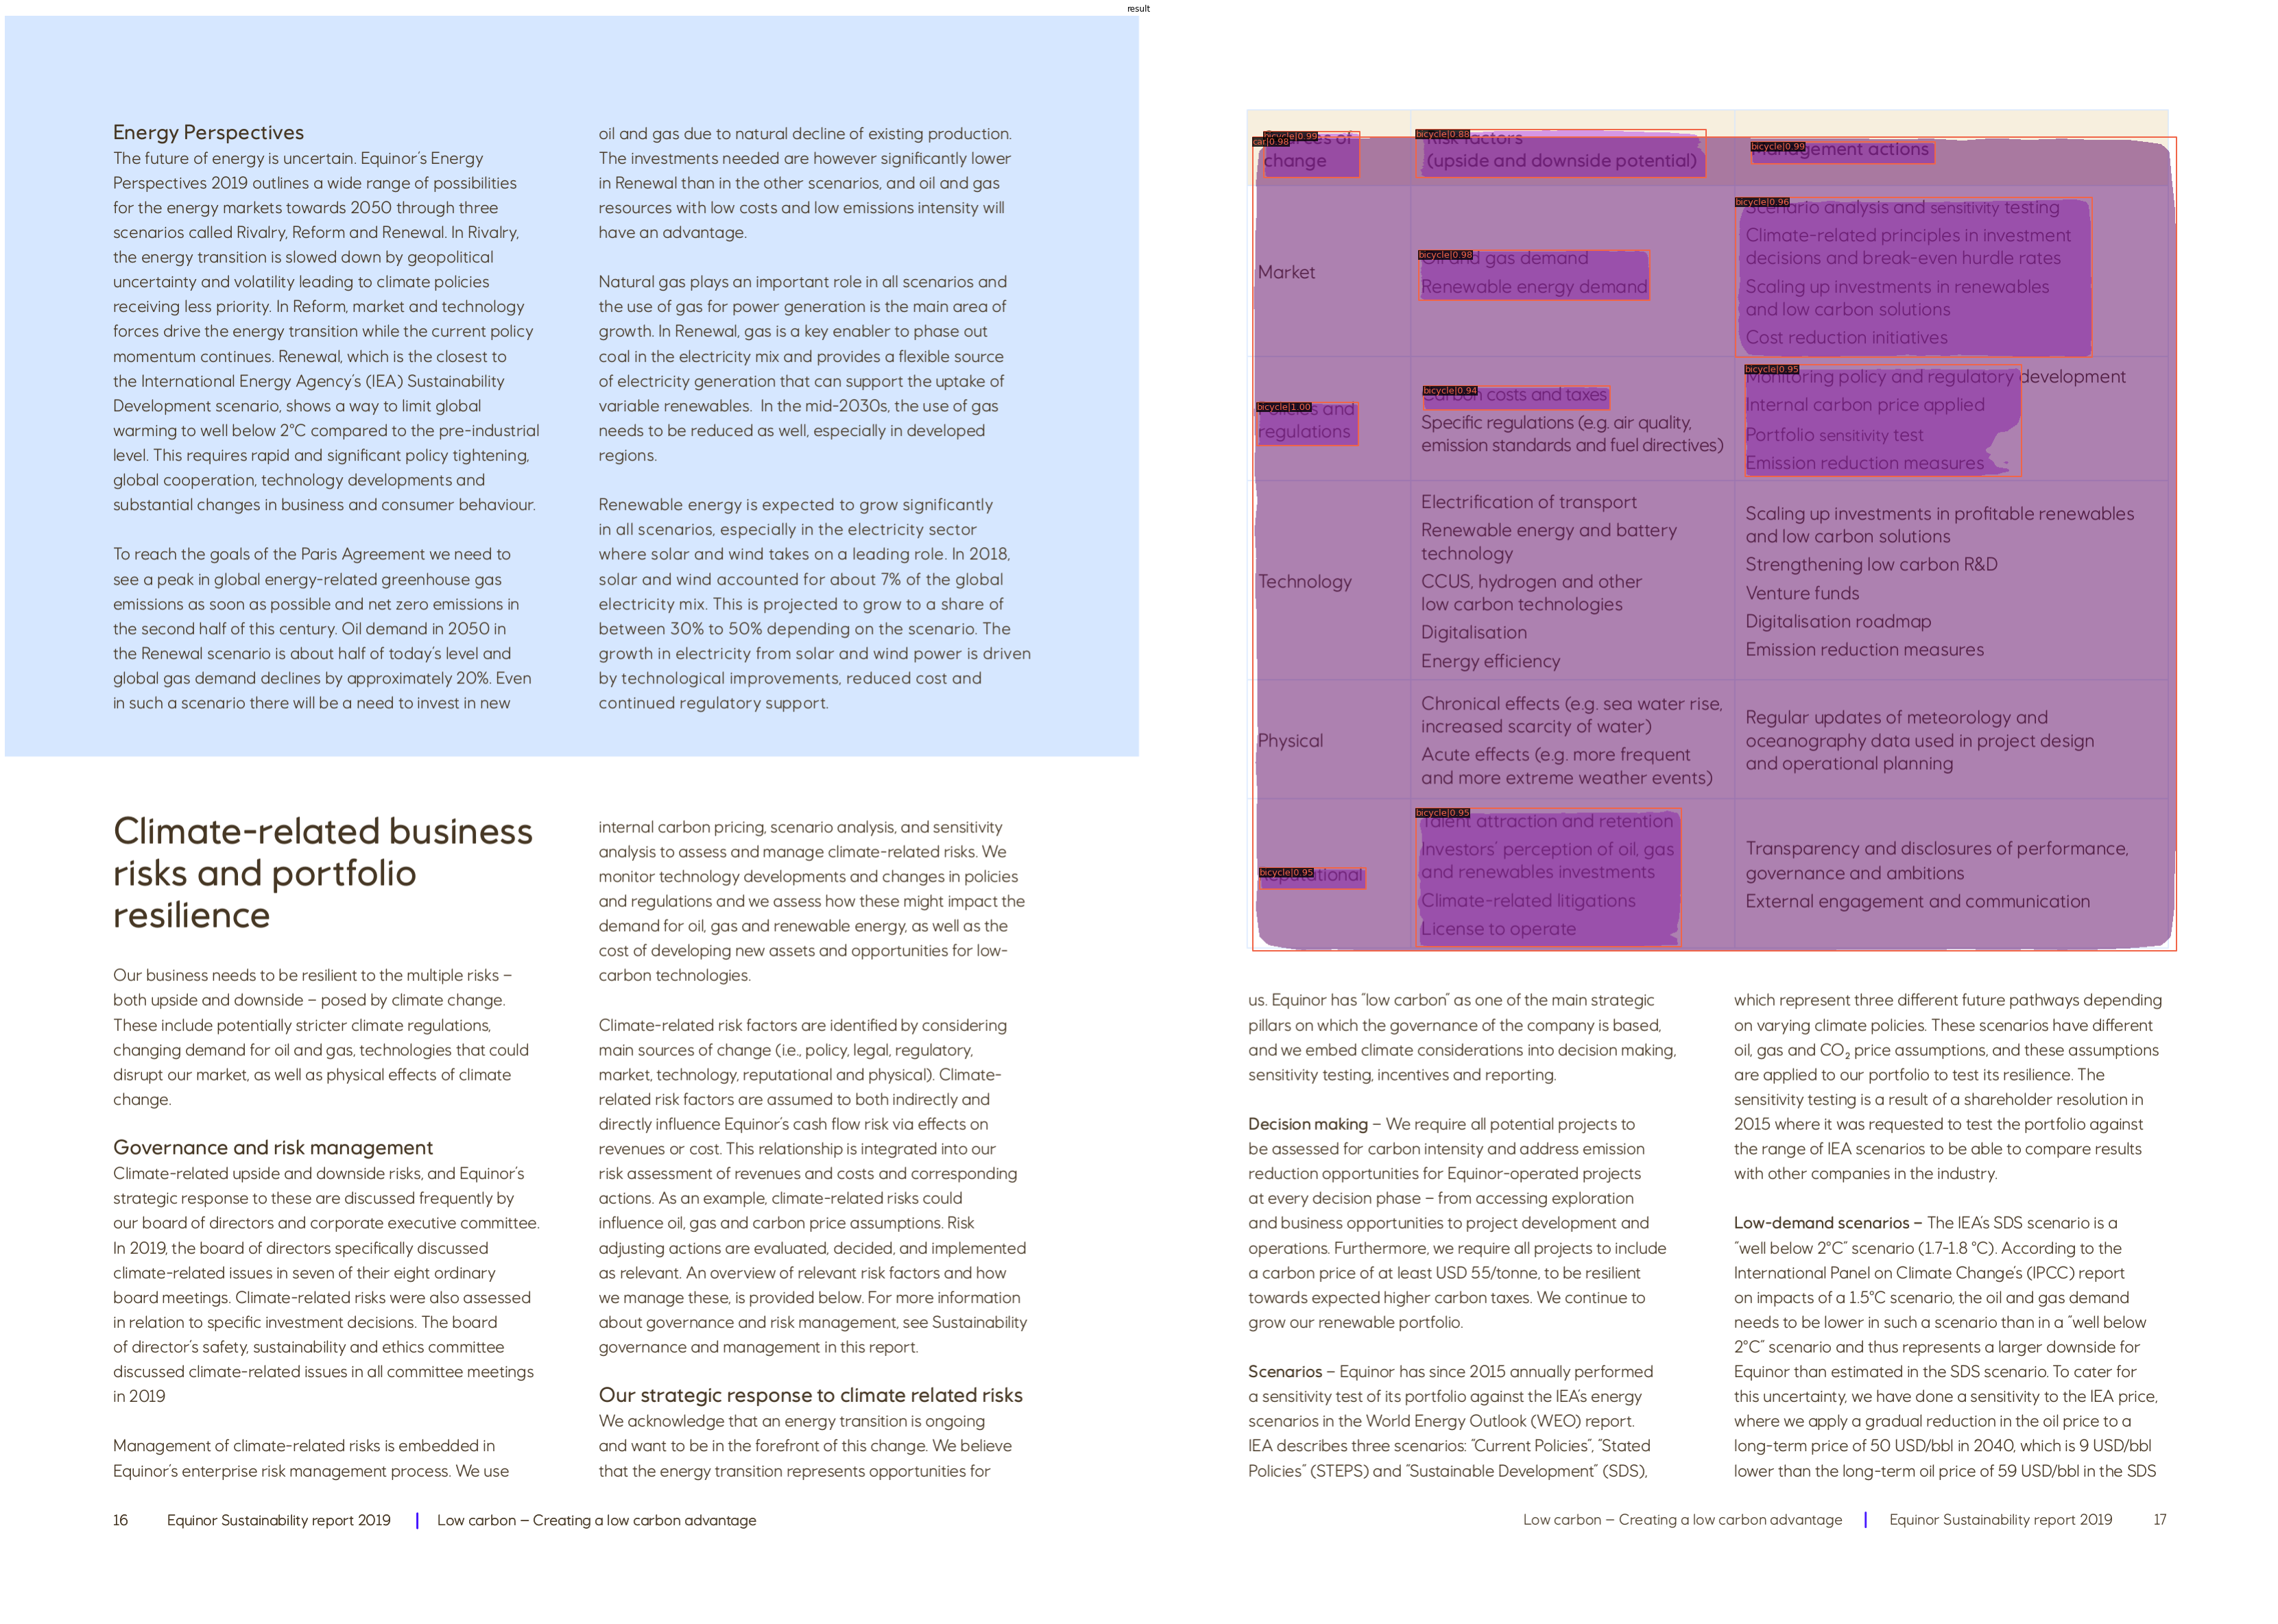

In [11]:
# visualize the tables
show_result_pyplot(
    model=table_extractor.model,
    img=np.array(images[page_num]),
    result=temp,
    score_thr=PDFTableExtractor_kwargs["bbox_thres"],
)

These steps are encapsulated in a single function in PDFTableExtractor, `infer_bbox()`

In [ ]:
# Infer bbox for each page
table_coords = table_extractor.infer_bbox(pdf_path)

Inferring tables for page 1-34:   0%|          | 0/33 [00:00<?, ?it/s]/opt/app-root/lib64/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/app-root/lib64/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(

Inferring tables for page 1-34:   3%|▎         | 1/33 [00:08<04:22,  8.21s/it]/opt/app-root/lib64/python3.8/site-packages/mmcv/utils/misc.py:323: UserWarning: "iou_thr" 

### 2. Extract Table using Tabula

`extract_table()` extracts tables using Tabula and saves them as csv in the extraction folder

In [ ]:
# convert from image to table
tables, tables_meta = table_extractor.extract_table(
    pdf_path, table_coords, config.BASE_EXTRACTION_FOLDER
)

In [ ]:
# view the extracted table from the sample page
tables[page_num + 1][0]

## Automate these processes using run_folder() function

We extract all tables from pdfs under the `corpdata/pdfs` key in our s3 bucket. Currently we only have one pdf in it, called `sustainability-report-2019.pdf`. This whole process will take approximately 3-5 minutes.

In [ ]:
# download all files from which tables are to be extracted
s3c.download_files_in_prefix_to_dir(
    config.BASE_PDF_S3_PREFIX,
    config.BASE_PDF_FOLDER,
)

In [ ]:
table_extractor.run_folder(config.BASE_PDF_FOLDER, config.BASE_EXTRACTION_FOLDER)

In [ ]:
# upload the extracted files to s3
s3c.upload_files_in_dir_to_prefix(
    config.BASE_EXTRACTION_FOLDER,
    config.BASE_EXTRACTION_S3_PREFIX
)

The extracted and parsed tables can now be found saved as csv's in extraction folder, `data/extraction`.

# Conclusion

In this notebook, we extracted the tables from the pdf, and saved them as csv files. Next, we will curate these extracted tables.